In [2]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
import pandas as pd
import os
from scipy import interpolate as interp
mpl.rcParams['font.size'] = 12

## Define the given parameters 

In [3]:
f_0 = 5.4*10**9   # Hz
ground_range_res = 5   # m
azim_res = 20   # m
incidence = np.radians (np.linspace (32, 40, 100))   # radians 
NESZ = -26   # dB
sigma_h = 0.015   # m
temp = 10   # celcius 
sand_frac = 0.51
clay_frac = 0.14
bulk_dens = 1.54   # g/cm^3
NDVI = np.linspace (0.1, 0.8, 100)
m_v = 0.2

## Assignment 1

In [4]:
# Calculate the dielectric constant of soil based on the previous assignment
def dielectric_water(f, T):
    e_inf = 4.9
    e_w0 = static_dia_water(T)
    rt = chill_t_water(T)

    test=e_inf+(e_w0-e_inf)/(1+np.pi*f*rt*2j)
    e_real=np.real(test)
    e_imag=np.imag(test)

    return e_real, e_imag

def chill_t_water(T):
    relax_t = (1.1109e-10 - 3.824e-12*T + 6.938e-14*T**2 - 5.096e-16*T**3) / (2*np.pi) # T in C
    return relax_t

def static_dia_water(T):
    e_w0 = 88.045 - 0.4147*T + 6.295*1e-4*T**2 + 1.075e-5*T**3
    return e_w0

def soil_dialectric (T,frq,mv,S,C,rho_bulk = 1.54):

    # Get the values for water that is in the soil
    water_real,water_imaginary=dielectric_water(frq,T)

    e_w0 = static_dia_water(T)


    # Empirical relations for soil values
    alpha = 0.65
    beta_1 = 1.27 - 0.519*S - 0.152 * C
    beta_2 = 2.06 - 0.928*S - 0.255 * C
    sigma_eff = -1.645 +1.939*rho_bulk - 2.256 * S +1.594*C

    #Need to add the extra term in the imaginary part of water to compensate for the soil texture

    extra_term = (2.65-rho_bulk)/(2.65*mv) * sigma_eff/(2*np.pi*e_w0*frq)
    water_imaginary+=extra_term

    real_soil=(1+0.66*rho_bulk+mv**(beta_1) *water_real**(alpha) -mv )**(1/alpha)
    imaginary_soil=mv**(beta_2)*water_imaginary

    return real_soil, imaginary_soil

# Calculate the real and imaginary parts of the dielectric constant
real,imag = soil_dialectric (temp, f_0, m_v, sand_frac, clay_frac)

In [5]:
# Small perturbation model
def GaussianSpectrum(kx, ky, sigma_h, l):
    # Do something... ideally your code works with both single values or with vectors or arrays
    # Here some dummy wrong code just to make an example plot
    S_G = sigma_h**2*(l**2/np.pi)*np.exp(-(kx**2+ky**2)*l**2/4)
    S_e = sigma_h**2 * (2*l**2)/(np.pi*(1+(kx**2+ky**2)*l**2)**(3/2))
    return S_G,S_e

def NRCS_SMP(f, theta_i, epsilon_r, spec_f, sigma_h, l):
    
    c=3*10**8
    lambda_0=c/f

    k_B = (2*np.pi)/(lambda_0/(2*np.sin(theta_i)))   
    k_0=k_B/(2*np.sin(theta_i))

    
    # rest of your code
    alpha_vv = (epsilon_r-1)*((epsilon_r-1)*(np.sin(theta_i)**2)+epsilon_r)/((epsilon_r*np.cos(theta_i))+np.sqrt(epsilon_r-(np.sin(theta_i)**2)))**2
    alpha_hh = (epsilon_r-1)/(np.cos(theta_i)+np.sqrt(epsilon_r-(np.sin(theta_i)**2)))

    _,S = spec_f(2*k_0*np.sin(theta_i), 0, sigma_h, l)

    NRCS_hh=4*np.pi*k_0**4 *np.cos(theta_i)**4 *np.abs(alpha_hh)**2 *S
    NRCS_vv=4*np.pi*k_0**4 *np.cos(theta_i)**4 *np.abs(alpha_vv)**2 *S

    return NRCS_hh, NRCS_vv

In [6]:
# Calculate the required autocorrelation length
angle_ex1 = np.radians (40)
hh1, vv1 = NRCS_SMP (f_0, angle_ex1, real, GaussianSpectrum, sigma_h, 4.4)
print (f"For l=3.0 sigma_vv is {vv1:.4f}")

For l=3.0 sigma_vv is 0.0101


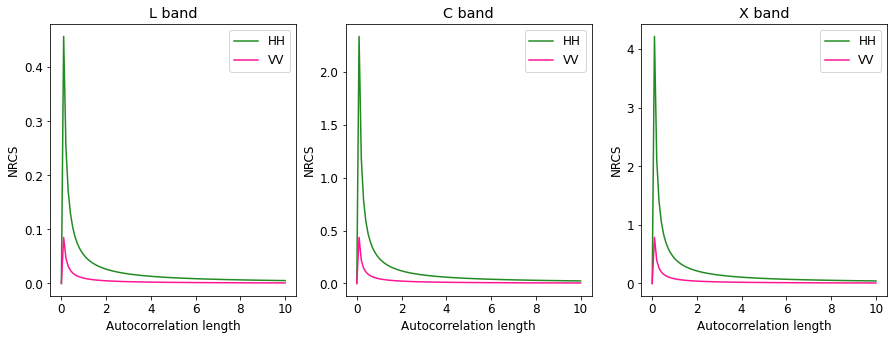

In [7]:
# Plot the NRCS as a function of autocorrelation length
l_array = np.linspace (0, 10, 100)

f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

# L band - 1.2 GHz
hhL, vvL = NRCS_SMP (1.2*10**9, angle_ex1, real, GaussianSpectrum, sigma_h, l_array)
ax1.plot (l_array, hhL, color='forestgreen', label='HH')
ax1.plot (l_array, vvL, color='deeppink', label='VV')
ax1.set_title ('L band')
ax1.set_xlabel ('Autocorrelation length')
ax1.set_ylabel ('NRCS')
ax1.legend ()

# C band - 5.4 GHz
hhC, vvC = NRCS_SMP (5.4*10**9, angle_ex1, real, GaussianSpectrum, sigma_h, l_array)
ax2.plot (l_array, hhC, color='forestgreen', label='HH')
ax2.plot (l_array, vvC, color='deeppink', label='VV')
ax2.set_title ('C band')
ax2.set_xlabel ('Autocorrelation length')
ax2.set_ylabel ('NRCS')
ax2.legend ()

# X band - 9.7 GHz
hhX, vvX = NRCS_SMP (9.7*10**9, angle_ex1, real, GaussianSpectrum, sigma_h, l_array)
ax3.plot (l_array, hhX, color='forestgreen', label='HH')
ax3.plot (l_array, vvX, color='deeppink', label='VV')
ax3.set_title ('X band')
ax3.set_xlabel ('Autocorrelation length')
ax3.set_ylabel ('NRCS')
ax3.legend ()


## Assignment 2

Text(0, 0.5, 'VV NRCS')

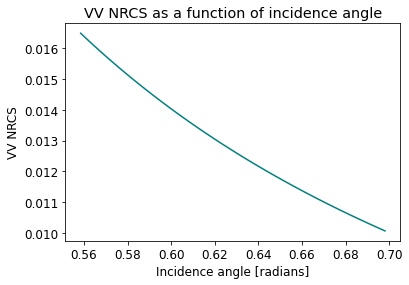

In [8]:
# Plot the VV against incidence angle 
hh2, vv2 = NRCS_SMP (f_0, incidence, real, GaussianSpectrum, sigma_h, 4.4)
plt.plot(incidence, vv2, color='teal')
plt.title('VV NRCS as a function of incidence angle')
plt.xlabel ('Incidence angle [radians]')
plt.ylabel ('VV NRCS')

## Assignment 3

In [9]:
# Combine the surface scattering component with the paper
# Define parameters from paper
A_VV = 0.0950
A_VH = 0.0413
B_VV = 0.5513
B_VH = 1.1662
V = NDVI

# Incidence angle = 32 degrees 

# m_v = 0.1
theta1 = np.radians (32)

# Calculate NRCS VV
real3a,imag3a = soil_dialectric (temp, f_0, 0.1, sand_frac, clay_frac)
hh32a, vv32a = NRCS_SMP (f_0, theta1, real3a, GaussianSpectrum, sigma_h, 4.4)

# NRCS VH = 0
vh32 = 0

# Calculate sigma_total based on the paper 
T_VV = np.exp (-2*B_VV*V*(1/np.cos(theta1)))
T_VH = np.exp (-2*B_VH*V*(1/np.cos(theta1)))

sigma_veg_VV32 = A_VV * V * np.cos (theta1) * (1-T_VV)
sigma_veg_VH32 = A_VH * V * np.cos (theta1) * (1-T_VH)

sigma_vv32_1 = sigma_veg_VV32 + T_VV * vv32a
sigma_vh32_1 = sigma_veg_VH32 + T_VH * vh32

# m_v = 0.25

# Calculate NRCS VV
real3b,imag3b = soil_dialectric (temp, f_0, 0.25, sand_frac, clay_frac)
hh32b, vv32b = NRCS_SMP (f_0, theta1, real3b, GaussianSpectrum, sigma_h, 4.4)

# NRCS VH = 0
vh32 = 0

# Calculate sigma_total based on the paper 
sigma_vv32_25 = sigma_veg_VV32 + T_VV * vv32b
sigma_vh32_25 = sigma_veg_VH32 + T_VH * vh32

In [10]:
# Incidence angle = 40 degrees 

# m_v = 0.1
theta2 = np.radians (40)

# Calculate NRCS VV
real3a,imag3a = soil_dialectric (temp, f_0, 0.1, sand_frac, clay_frac)
hh40a, vv40a = NRCS_SMP (f_0, theta2, real3a, GaussianSpectrum, sigma_h, 4.4)

# NRCS VH = 0
vh40 = 0

# Calculate sigma_total based on the paper 
T_VV = np.exp (-2*B_VV*V*(1/np.cos(theta2)))
T_VH = np.exp (-2*B_VH*V*(1/np.cos(theta2)))

sigma_veg_VV40 = A_VV * V * np.cos (theta2) * (1-T_VV)
sigma_veg_VH40 = A_VH * V * np.cos (theta2) * (1-T_VH)

sigma_vv40_1 = sigma_veg_VV40 + T_VV * vv40a
sigma_vh40_1 = sigma_veg_VH40 + T_VH * vh40

# m_v = 0.25

# Calculate NRCS VV
real3b,imag3b = soil_dialectric (temp, f_0, 0.25, sand_frac, clay_frac)
hh40b, vv40b = NRCS_SMP (f_0, theta2, real3b, GaussianSpectrum, sigma_h, 4.4)

# NRCS VH = 0
vh40 = 0

# Calculate sigma_total based on the paper 
sigma_vv40_25 = sigma_veg_VV40 + T_VV * vv40b
sigma_vh40_25 = sigma_veg_VH40 + T_VH * vh40

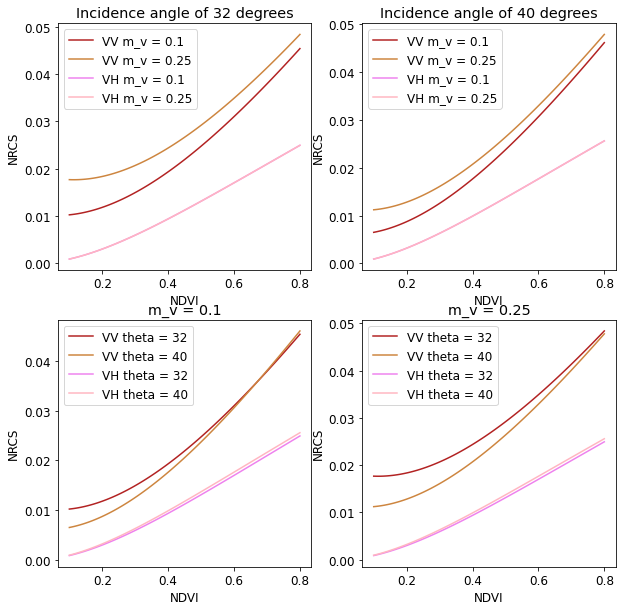

In [11]:
# Make the plots 
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten() 

ax1.plot (NDVI, sigma_vv32_1, color='firebrick', label='VV m_v = 0.1' )
ax1.plot (NDVI, sigma_vv32_25, color='peru', label='VV m_v = 0.25' )
ax1.plot (NDVI, sigma_vh32_1, color='violet', label='VH m_v = 0.1' )
ax1.plot (NDVI, sigma_vh32_25, color='lightpink', label='VH m_v = 0.25' )
ax1.set_title ('Incidence angle of 32 degrees')
ax1.set_xlabel ('NDVI')
ax1.set_ylabel ('NRCS')
ax1.legend ()

ax2.plot (NDVI, sigma_vv40_1, color='firebrick', label='VV m_v = 0.1' )
ax2.plot (NDVI, sigma_vv40_25, color='peru', label='VV m_v = 0.25' )
ax2.plot (NDVI, sigma_vh40_1, color='violet', label='VH m_v = 0.1' )
ax2.plot (NDVI, sigma_vh40_25, color='lightpink', label='VH m_v = 0.25' )
ax2.set_title ('Incidence angle of 40 degrees')
ax2.set_xlabel ('NDVI')
ax2.set_ylabel ('NRCS')
ax2.legend ()

ax3.plot (NDVI, sigma_vv32_1, color='firebrick', label='VV theta = 32' )
ax3.plot (NDVI, sigma_vv40_1, color='peru', label='VV theta = 40' )
ax3.plot (NDVI, sigma_vh32_1, color='violet', label='VH theta = 32' )
ax3.plot (NDVI, sigma_vh40_1, color='lightpink', label='VH theta = 40' )
ax3.set_title ('m_v = 0.1')
ax3.set_xlabel ('NDVI')
ax3.set_ylabel ('NRCS')
ax3.legend ()

ax4.plot (NDVI, sigma_vv32_25, color='firebrick', label='VV theta = 32' )
ax4.plot (NDVI, sigma_vv40_25, color='peru', label='VV theta = 40' )
ax4.plot (NDVI, sigma_vh32_25, color='violet', label='VH theta = 32' )
ax4.plot (NDVI, sigma_vh40_25, color='lightpink', label='VH theta = 40' )
ax4.set_title ('m_v = 0.25')
ax4.set_xlabel ('NDVI')
ax4.set_ylabel ('NRCS')
ax4.legend ()

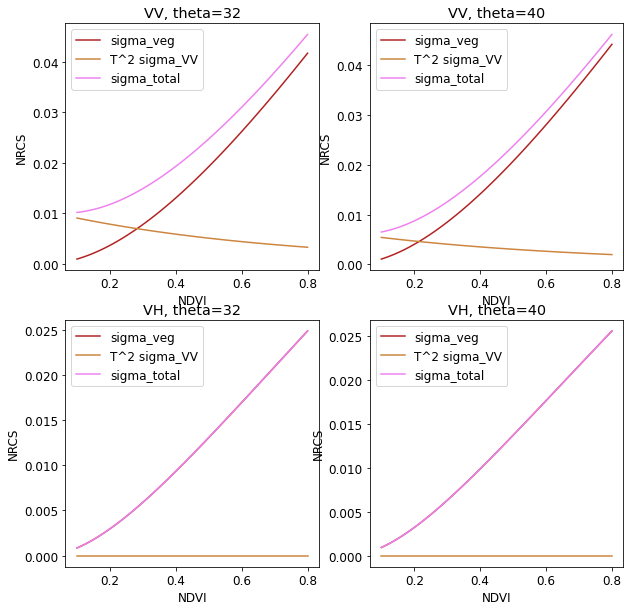

In [12]:
# Make the plots - figure 5 replica m_v = 0.1
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten() 

ax1.plot (NDVI, sigma_veg_VV32, color='firebrick', label='sigma_veg' )
ax1.plot (NDVI, T_VV * vv32a, color='peru', label='T^2 sigma_VV' )
ax1.plot (NDVI, sigma_vv32_1, color='violet', label='sigma_total' )
ax1.set_title ('VV, theta=32')
ax1.set_xlabel ('NDVI')
ax1.set_ylabel ('NRCS')
ax1.legend ()

ax2.plot (NDVI, sigma_veg_VV40, color='firebrick', label='sigma_veg' )
ax2.plot (NDVI, T_VV * vv40a, color='peru', label='T^2 sigma_VV' )
ax2.plot (NDVI, sigma_vv40_1, color='violet', label='sigma_total' )
ax2.set_title ('VV, theta=40')
ax2.set_xlabel ('NDVI')
ax2.set_ylabel ('NRCS')
ax2.legend ()

ax3.plot (NDVI, sigma_veg_VH32, color='firebrick', label='sigma_veg' )
ax3.plot (NDVI, T_VH * vh32, color='peru', label='T^2 sigma_VV' )
ax3.plot (NDVI, sigma_vh32_1, color='violet', label='sigma_total' )
ax3.set_title ('VH, theta=32')
ax3.set_xlabel ('NDVI')
ax3.set_ylabel ('NRCS')
ax3.legend ()

ax4.plot (NDVI, sigma_veg_VH40, color='firebrick', label='sigma_veg' )
ax4.plot (NDVI, T_VH * vh40, color='peru', label='T^2 sigma_VV' )
ax4.plot (NDVI, sigma_vh40_1, color='violet', label='sigma_total' )
ax4.set_title ('VH, theta=40')
ax4.set_xlabel ('NDVI')
ax4.set_ylabel ('NRCS')
ax4.legend ()

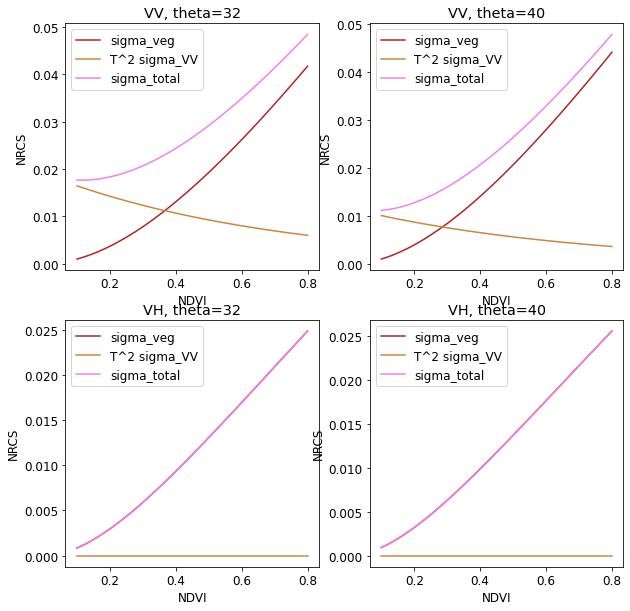

In [13]:
# Make the plots - figure 5 replica m_v = 0.25
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten() 

ax1.plot (NDVI, sigma_veg_VV32, color='firebrick', label='sigma_veg' )
ax1.plot (NDVI, T_VV * vv32b, color='peru', label='T^2 sigma_VV' )
ax1.plot (NDVI, sigma_vv32_25, color='violet', label='sigma_total' )
ax1.set_title ('VV, theta=32')
ax1.set_xlabel ('NDVI')
ax1.set_ylabel ('NRCS')
ax1.legend ()

ax2.plot (NDVI, sigma_veg_VV40, color='firebrick', label='sigma_veg' )
ax2.plot (NDVI, T_VV * vv40b, color='peru', label='T^2 sigma_VV' )
ax2.plot (NDVI, sigma_vv40_25, color='violet', label='sigma_total' )
ax2.set_title ('VV, theta=40')
ax2.set_xlabel ('NDVI')
ax2.set_ylabel ('NRCS')
ax2.legend ()

ax3.plot (NDVI, sigma_veg_VH32, color='firebrick', label='sigma_veg' )
ax3.plot (NDVI, T_VH * vh32, color='peru', label='T^2 sigma_VV' )
ax3.plot (NDVI, sigma_vh32_25, color='violet', label='sigma_total' )
ax3.set_title ('VH, theta=32')
ax3.set_xlabel ('NDVI')
ax3.set_ylabel ('NRCS')
ax3.legend ()

ax4.plot (NDVI, sigma_veg_VH40, color='firebrick', label='sigma_veg' )
ax4.plot (NDVI, T_VH * vh40, color='peru', label='T^2 sigma_VV' )
ax4.plot (NDVI, sigma_vh40_25, color='violet', label='sigma_total' )
ax4.set_title ('VH, theta=40')
ax4.set_xlabel ('NDVI')
ax4.set_ylabel ('NRCS')
ax4.legend ()

## Assignment 4

remember to install drama with pip install drama

In [14]:
from drama import utils

Let us assume a small area, for example 1x1 km2 (how many pixels do you have in range and in azimuth), with the scene characteristics constant in squares of 100x100 m2 . You an assume that the observation geometry (angle of incidence) is constant over the 1x1 km2 area.

okay so, Total 1000 x 1000 m (1x1 km^2) with each square size as 100 m x 100 m.
The goal is to divide the area into smaller pixels in the azimuth (vertical) and range (horizontal) directions.

Sentinel-1 provides the range and azimuth resolutions:
ground_range_res = 5   # m
azim_res = 20   # m

Number of azimuth pixels = Area height / azim_res = 1000 / 20 = 50
Number of range pixels = Area height / range_res = 1000 / 5 = 200

the simulated radar image will have a size of 50×200 pixels.


In [15]:
def chessboard_nrcs(shape, nrcs_black=0.01, nrcs_white=0.1, square_size=100, daz=20, dgr=5):
    """ Creates a chessboard pattern
    
    Args:
        shape: shape of output matrix
        nrcs_black (float):  nrcs for black squares. User decides if these are db or linear values.
        nrcs_white (float): nrcs for white squares...
        square_size (float): size of each square, in meters. Defaults to 100.
        daz (float): azimuth resolution (or in this case sampling). Defaults to 20 m.
        dgr (float): ground range resolution (sampling). Defaults to 5 m.
        
    """
    # This can be done in many ways, so do not put too much value in this particular implementation.
    aind = np.arange(shape[0]).reshape((shape[0], 1))
    rind = np.arange(shape[1]).reshape((1, shape[1]))
    apat = np.int32(aind*daz/square_size)
    rpat = np.int32(rind*dgr/square_size)
    chess_board = np.mod(apat + rpat, 2)
    chess_board = chess_board * (nrcs_white - nrcs_black) + nrcs_black
    return chess_board

def moving_average(data, Naz, Nrg, downsample=False):
    """ A moving average filter for you
    Args:
        data: 2D numpy array
        Naz: number of samples averaged in azimuth (first dimension)
        Nrg: number of samples averaged in range (second dimension)
        downsample: True if you want to downsample after averaging
    """
    filt_data = utils.smooth(utils.smooth(data, Nrg, axis=1), Naz, axis=0)
    if downsample:
        filt_data = filt_data[int(Naz/2)::Naz, int(Nrg/2)::Nrg]
    return filt_data

In [16]:

shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
square_size = 100  # Size of each square in meters
daz = 20  # Azimuth resolution
dgr = 5   # Range resolution

#Example
ex_nrcs = chessboard_nrcs(shape, nrcs_black=0.01, nrcs_white=0.1, 
                       square_size=square_size, daz=daz, dgr=dgr)



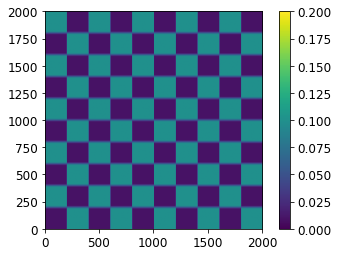

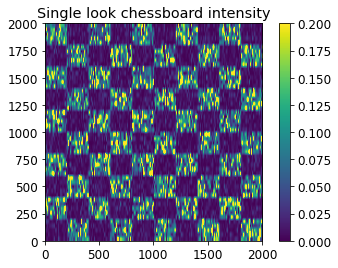

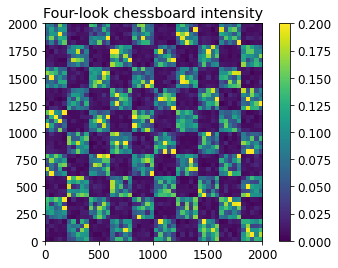

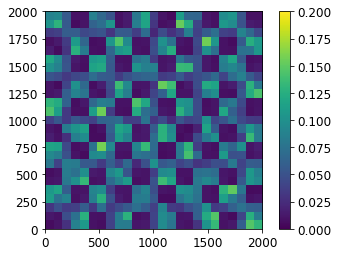

In [17]:
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)

# Let is try it, this shows the pattern without speckle
cbrd_nrcs = chessboard_nrcs(shape, 0.01, 0.1, square_size)
plt.figure()
plt.imshow(cbrd_nrcs, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
plt.colorbar()


# Now to simulate an SAR image we need to multiply the random speckle by the deterministic pattern:
cbrd_slc  = np.sqrt(cbrd_nrcs/2) * (np.random.randn(50,200) + 1j*np.random.randn(50,200))
plt.figure()
plt.imshow(np.abs(cbrd_slc)**2, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
plt.title("Single look chessboard intensity")
plt.colorbar()


#Naz and Nrg choosen as 1, 4 for 4 looks, 2, 8 for 16 looks 5, 20 for 100 looks

# We can do some multilooking
cbrd_int_4looks = moving_average(np.abs(cbrd_slc)**2, 1, 4, downsample=True)
plt.figure()
plt.imshow(cbrd_int_4looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
plt.title("Four-look chessboard intensity")
plt.colorbar()


cbrd_int_16looks = moving_average(np.abs(cbrd_slc)**2, 2, 8, downsample=True)
plt.figure()
plt.imshow(cbrd_int_16looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
#plt.title("Four-look chessboard intensity")
plt.colorbar()

In [18]:
from scipy.stats import rayleigh, expon

shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
square_size = 100  # Size of each square in meters
daz = 20  # Azimuth resolution
dgr = 5   # Range resolution
Naz = 1
Nrg = 4


#Example
ex_nrcs = chessboard_nrcs(shape, nrcs_black=0.01, nrcs_white=0.1, 
                       square_size=square_size, daz=daz, dgr=dgr)


def moving_average(data, Naz, Nrg, downsample=False):
    filt_data = utils.smooth(utils.smooth(data, Nrg, axis=1), Naz, axis=0)
    if downsample:
        filt_data = filt_data[int(Naz/2)::Naz, int(Nrg/2)::Nrg]
    return filt_data


def plot_hist_Rayl_exp(one_pixel_nrcs, shape, Naz, Nrg):
    slc = np.sqrt(one_pixel_nrcs/2)*(np.random.randn(shape[0],shape[1])+1j*np.random.randn(shape[0],shape[1]))
    amp = np.abs(slc)
    intensity = np.abs(slc)**2

    x_amp = np.linspace(0, amp.max(), 500)
    x_int = np.linspace(0, intensity.max(), 500)

    #numb = Naz*Nrg

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(amp.flatten(), bins=100, density=True, color='skyblue', alpha=0.7, label='Histogram')
    plt.plot(x_amp, rayleigh.pdf(x_amp, scale=np.mean(amp) * np.sqrt(np.pi / 2)), 'r-', lw=2, label='Rayleigh Fit')
    plt.title(f'Amplitude Hist')
    plt.xlabel('|SLC|')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(intensity.flatten(), bins=100, density=True, color='salmon', alpha=0.7, label='Histogram')
    plt.plot(x_int, expon.pdf(x_int, scale=np.mean(intensity)), 'r-', lw=2, label="Exponential Fit")
    plt.title(f'Intensity')
    plt.xlabel('|SLC|^2')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    amp_mean = np.mean(amp)
    amp_std = np.std(amp)
    intensity_mean = np.mean(intensity)
    intensity_std = np.std(intensity)

    print(f"Amplitude Mean: {amp_mean:.4f}, Amplitude Std Dev: {amp_std:.4f}.")
    print(f"Intensity Mean: {intensity_mean:.4f}, Intensity Std Dev: {intensity_std:.4f}.")

In [57]:
np.random.seed(0)  # For reproducibility
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
nrcs = 0.0217
slc = np.sqrt(nrcs/2) * (np.random.randn(*shape) + 1j * np.random.randn(*shape))

# Compute the squared amplitude (intensity)
intensity = np.abs(slc)**2  # Squared amplitude

# Apply multilooking (average intensities)
# For example: 4 looks = 1x4 window
Naz, Nrg = 1, 4
intensity_4looks = moving_average(intensity, Naz, Nrg, downsample=True)

# For 16 looks = 2x8 window
Naz, Nrg = 2, 8
intensity_16looks = moving_average(intensity, Naz, Nrg, downsample=True)

# For 100 looks = 5x20 window
Naz, Nrg = 5, 20
intensity_100looks = moving_average(intensity, Naz, Nrg, downsample=True)

# Print shapes and stats
print("Original intensity shape:", intensity.shape)
print("4-looks intensity shape:", intensity_4looks.shape)
print("16-looks intensity shape:", intensity_16looks.shape)
print("100-looks intensity shape:", intensity_100looks.shape)

print("\nMean and Standard Deviation:")
print(f"4 Looks -> Mean: {np.mean(intensity_4looks):.4f}, Std: {np.std(intensity_4looks):.4f}")
print(f"16 Looks -> Mean: {np.mean(intensity_16looks):.4f}, Std: {np.std(intensity_16looks):.4f}")
print(f"100 Looks -> Mean: {np.mean(intensity_100looks):.4f}, Std: {np.std(intensity_100looks):.4f}")

Original intensity shape: (50, 200)
4-looks intensity shape: (50, 50)
16-looks intensity shape: (25, 25)
100-looks intensity shape: (10, 10)

Mean and Standard Deviation:
4 Looks -> Mean: 0.0213, Std: 0.0105
16 Looks -> Mean: 0.0213, Std: 0.0051
100 Looks -> Mean: 0.0213, Std: 0.0020


In [20]:
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
square_size = 100  # Size of each square in meters
daz = 20  # Azimuth resolution
dgr = 5   # Range resolution

#Example
ex_nrcs = chessboard_nrcs(shape, nrcs_black=0.01, nrcs_white=0.1, 
                       square_size=square_size, daz=daz, dgr=dgr)

In [55]:
# Example SLC data (simulate radar image with speckle)
np.random.seed(0)  # For reproducibility
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
nrcs = 0.0217
slc = np.sqrt(nrcs/2) * (np.random.randn(*shape) + 1j * np.random.randn(*shape))

# Compute the squared amplitude (intensity)
intensity = np.abs(slc)**2  # Squared amplitude


def plot_intensity(intensity, Naz, Nrg):
    intensity = moving_average(intensity, Naz, Nrg, downsample=True)
    
    plt.figure()
    plt.hist(intensity.flatten(), bins=100, density=True, color='salmon', alpha=0.7, label='Histogram')
    numb_looks = Naz*Nrg
    plt.title(f'Intensity {numb_looks} looks')
    plt.xlabel('|SLC|^2')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

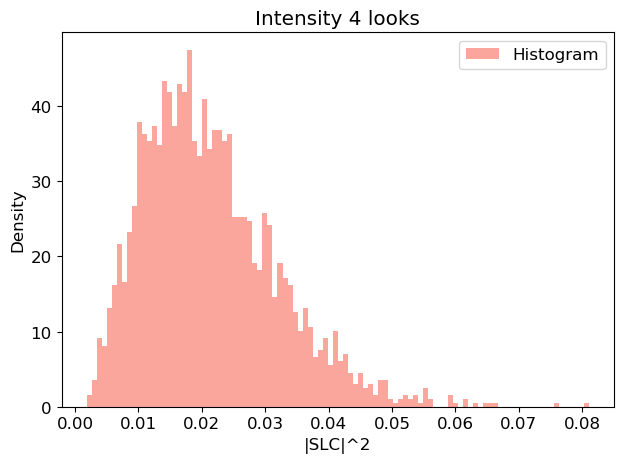

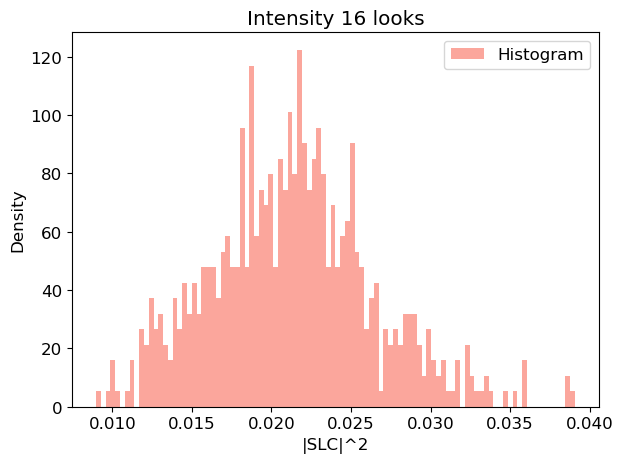

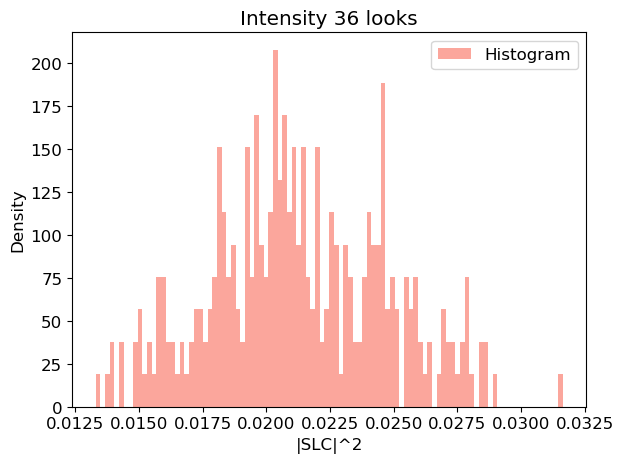

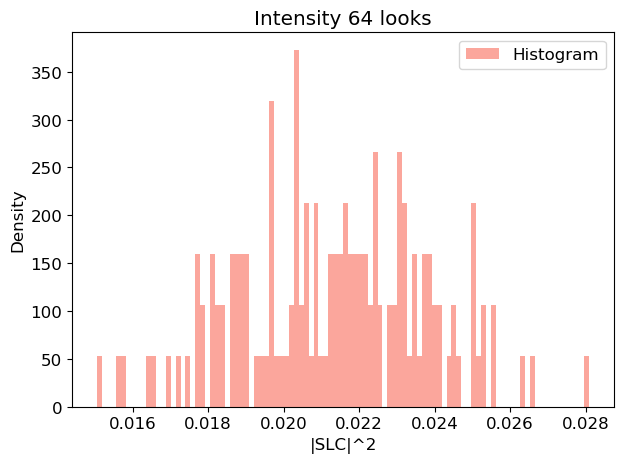

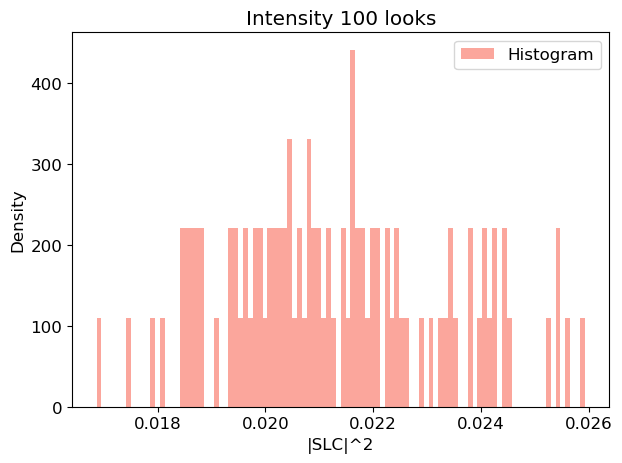

In [56]:

plot_intensity(intensity, 1, 4)
plot_intensity(intensity, 2, 8)
plot_intensity(intensity, 3, 12)
plot_intensity(intensity, 4, 16)
plot_intensity(intensity, 5, 20)



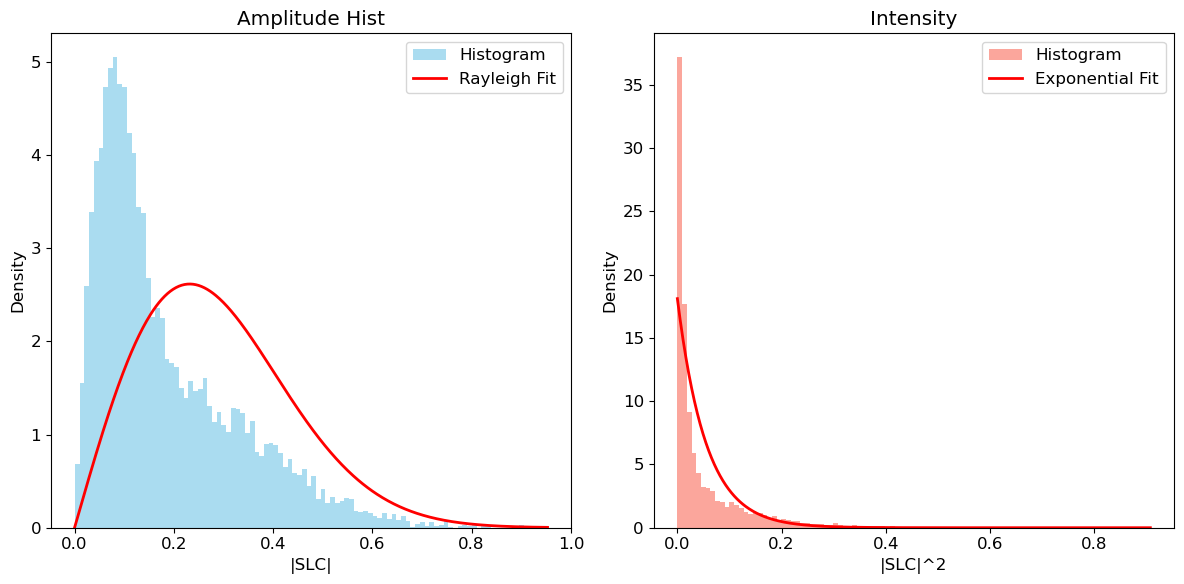

Amplitude Mean: 0.1851, Amplitude Std Dev: 0.1448.
Intensity Mean: 0.0552, Intensity Std Dev: 0.0848.


In [50]:
plot_hist_Rayl_exp(ex_nrcs, shape, 1, 4)

In [48]:
# Calculate NRCS VV
real3a,imag3a = soil_dialectric (temp, f_0, 0.1, sand_frac, clay_frac)

hh40a, vv40a = NRCS_SMP (f_0, theta2, real3a, GaussianSpectrum, sigma_h, 4.4)

theta = np.radians(40)

def sigma_total_aka_nrcs(real3a, hh40a, vv40a, NDVI, theta):
    A_VV = 0.0950
    A_VH = 0.0413
    B_VV = 0.5513
    B_VH = 1.1662
    V = NDVI

    T_VV = np.exp (-2*B_VV*V*(1/np.cos(theta)))
    T_VH = np.exp (-2*B_VH*V*(1/np.cos(theta)))

    sigma_veg_VV40 = A_VV * V * np.cos (theta) * (1-T_VV)
    sigma_veg_VH40 = A_VH * V * np.cos (theta) * (1-T_VH)

    sigma_vv40_1 = sigma_veg_VV40 + T_VV * vv40a
    sigma_vh40_1 = sigma_veg_VH40 + T_VH * vh40

    return sigma_vv40_1, sigma_vh40_1

vvnrcs_ndvi_05,_ = sigma_total_aka_nrcs(real3a, hh40a, vv40a, 0.5, theta) # White 
_,vhnrcs_ndvi_05 = sigma_total_aka_nrcs(real3a, hh40a, vv40a, 0.5, theta) # White 
vvnrcs_ndvi_0,_ = sigma_total_aka_nrcs(real3a, hh40a, vv40a, 0, theta) # Black
_,vhnrcs_ndvi_0 = sigma_total_aka_nrcs(real3a, hh40a, vv40a, 0, theta)

print(f'For VV polarisation, a square of NDVI = 0.5, the value for white square nrcs = {vvnrcs_ndvi_05:.4f}')
print(f'For VV polarisation, a square of NDVI = 0, the value for black square nrcs = {vvnrcs_ndvi_0:.4f}')

print(f'For VH polarisation, a square of NDVI = 0.5, the value for white square nrcs = {vhnrcs_ndvi_05:.4f}')
print(f'For VH polarisation, a square of NDVI = 0, the value for black square nrcs = {vhnrcs_ndvi_0:.4f}')
    
    

For VV polarisation, a square of NDVI = 0.5, the value for white square nrcs = 0.0217
For VV polarisation, a square of NDVI = 0, the value for white square nrcs = 0.0063
For VH polarisation, a square of NDVI = 0.5, the value for white square nrcs = 0.0124
For VH polarisation, a square of NDVI = 0, the value for white square nrcs = 0.0000


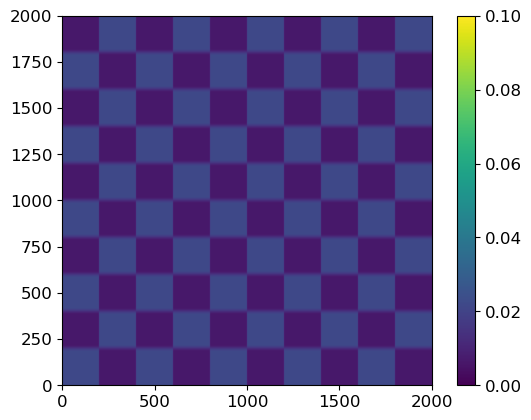

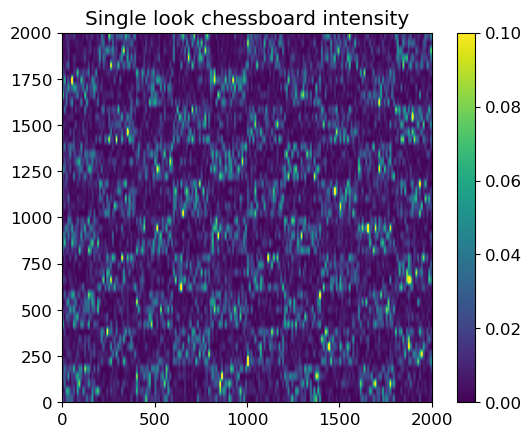

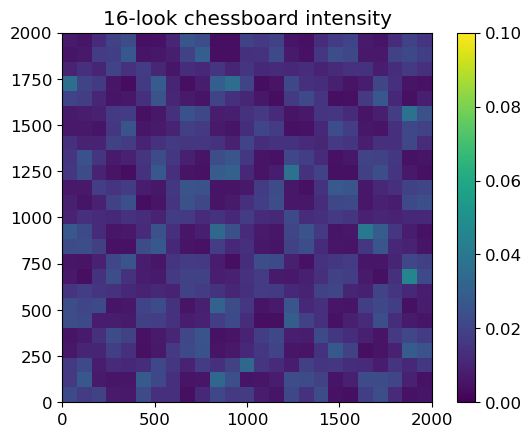

In [49]:
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)

# Let is try it, this shows the pattern without speckle
cbrd_nrcs = chessboard_nrcs(shape, vvnrcs_ndvi_05, vvnrcs_ndvi_0, square_size)
plt.figure()
plt.imshow(cbrd_nrcs, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.1)
plt.colorbar()

# Now to simulate an SAR image we need to multiply the random speckle by the deterministic pattern:
cbrd_slc  = np.sqrt(cbrd_nrcs/2) * (np.random.randn(50,200) + 1j*np.random.randn(50,200))
plt.figure()
plt.imshow(np.abs(cbrd_slc)**2, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.1)
plt.title("Single look chessboard intensity")
plt.colorbar()

cbrd_int_16looks = moving_average(np.abs(cbrd_slc)**2, 2, 8, downsample=True)
plt.figure()
plt.imshow(cbrd_int_16looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.1)
plt.title("16-look chessboard intensity")
plt.colorbar()

## Assignnment 7

In [28]:
np.random.seed(0)  # For reproducibility
shape = (50, 200)  # 50 rows (azimuth) x 200 columns (range)
nrcs = 0.1

nesz = -26      # dB
thermal_noise = 10**(nesz/10)  # Convert dB to linear scale

new_nrcs = nrcs + thermal_noise

slc = np.sqrt(new_nrcs/2) * (np.random.randn(*shape) + 1j * np.random.randn(*shape))

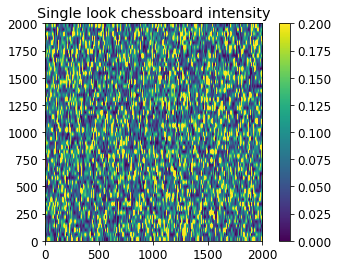

In [31]:

# Now to simulate an SAR image we need to multiply the random speckle by the deterministic pattern:
plt.figure()
plt.imshow(np.abs(slc)**2, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.2)
plt.title("Single look chessboard intensity")
plt.colorbar()


#Naz and Nrg choosen as 1, 4 for 4 looks, 2, 8 for 16 looks 5, 20 for 100 looks

